Using device: cuda
Starting training...


Training NeRF:   8%|▊         | 1002/12000 [00:36<06:59, 26.24iter/s]

Iteration 1000: Loss=0.0155, Photo=0.0147, Sil=0.0468, Shape=0.0106, Density=0.0061, Smooth=0.0940
Checkpoint saved at iteration 1000


Training NeRF:  17%|█▋        | 2003/12000 [01:10<05:50, 28.54iter/s]

Iteration 2000: Loss=0.0177, Photo=0.0169, Sil=0.0499, Shape=0.0071, Density=0.0096, Smooth=0.0652
Checkpoint saved at iteration 2000


Training NeRF:  25%|██▌       | 3004/12000 [01:47<06:06, 24.58iter/s]

Iteration 3000: Loss=0.0140, Photo=0.0134, Sil=0.0432, Shape=0.0097, Density=0.0059, Smooth=0.0246
Checkpoint saved at iteration 3000


Training NeRF:  33%|███▎      | 4004/12000 [02:22<04:54, 27.11iter/s]

Iteration 4000: Loss=0.0151, Photo=0.0146, Sil=0.0351, Shape=0.0079, Density=0.0091, Smooth=0.0461
Checkpoint saved at iteration 4000


Training NeRF:  42%|████▏     | 5003/12000 [02:58<03:59, 29.19iter/s]

Iteration 5000: Loss=0.0147, Photo=0.0142, Sil=0.0357, Shape=0.0066, Density=0.0057, Smooth=0.0397
Checkpoint saved at iteration 5000


Training NeRF:  50%|█████     | 6004/12000 [03:32<03:32, 28.24iter/s]

Iteration 6000: Loss=0.0162, Photo=0.0157, Sil=0.0433, Shape=0.0048, Density=0.0005, Smooth=0.0501
Checkpoint saved at iteration 6000


Training NeRF:  58%|█████▊    | 7003/12000 [04:08<03:03, 27.19iter/s]

Iteration 7000: Loss=0.0157, Photo=0.0152, Sil=0.0367, Shape=0.0083, Density=0.0009, Smooth=0.0353
Checkpoint saved at iteration 7000


Training NeRF:  67%|██████▋   | 8004/12000 [04:44<02:25, 27.53iter/s]

Iteration 8000: Loss=0.0162, Photo=0.0157, Sil=0.0373, Shape=0.0088, Density=0.0019, Smooth=0.0487
Checkpoint saved at iteration 8000


Training NeRF:  75%|███████▌  | 9005/12000 [05:21<01:36, 31.03iter/s]

Iteration 9000: Loss=0.0165, Photo=0.0159, Sil=0.0438, Shape=0.0064, Density=0.0030, Smooth=0.0284
Checkpoint saved at iteration 9000


Training NeRF:  83%|████████▎ | 10003/12000 [05:52<01:03, 31.29iter/s]

Iteration 10000: Loss=0.0143, Photo=0.0138, Sil=0.0369, Shape=0.0073, Density=0.0052, Smooth=0.0251
Checkpoint saved at iteration 10000


Training NeRF:  92%|█████████▏| 11004/12000 [06:24<00:36, 27.02iter/s]

Iteration 11000: Loss=0.0165, Photo=0.0160, Sil=0.0357, Shape=0.0075, Density=0.0024, Smooth=0.0412
Checkpoint saved at iteration 11000


Training NeRF: 100%|██████████| 12000/12000 [06:56<00:00, 28.82iter/s]


Iteration 12000: Loss=0.0143, Photo=0.0138, Sil=0.0403, Shape=0.0091, Density=0.0026, Smooth=0.0353
Checkpoint saved at iteration 12000
Training done. Extracting 3D volume...
Extracting 3D volume...
Sigma volume stats: min=0.0000, max=23.2139, mean=0.1173, std=0.7174
Using iso-level: 0.8347
Saved mesh to 'nerf_reconstruction.stl'
Chamfer Distance (Prediction vs GT): 3681.216772


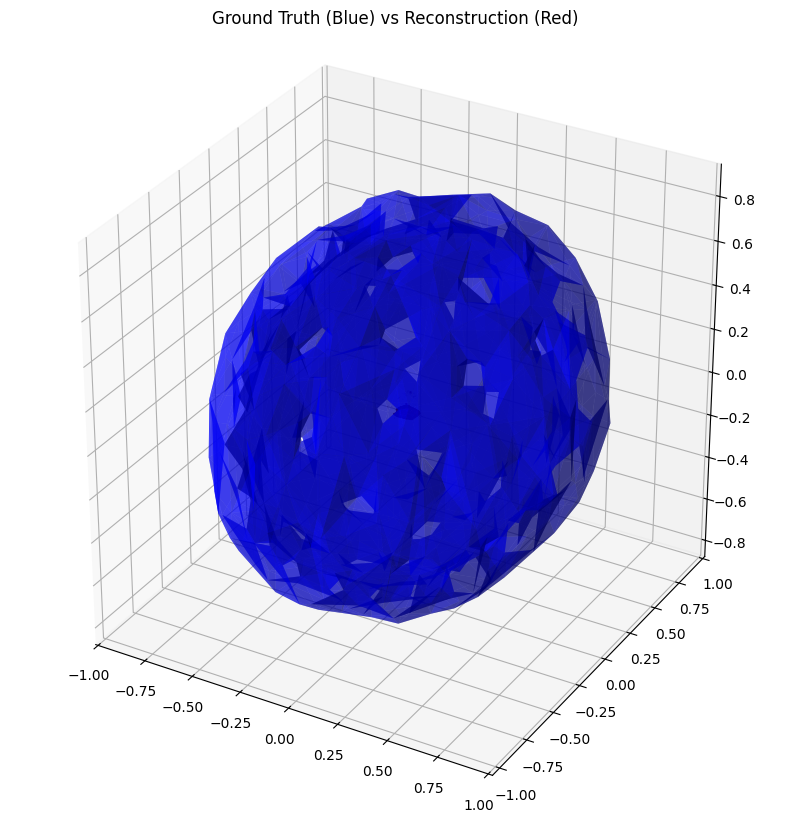

In [ ]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

sys.path.append("..")
from data.pollen_dataset import PollenDataset, get_train_test_split
torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

################################################################################
# 1. Positional Encoding
################################################################################
def positional_encoding(x, L=10):
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)

################################################################################
# 2. NeRF Model with Positional Encoding
################################################################################
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, L=10):
        super(NeRF, self).__init__()
        self.L = L
        in_channels = 3 * (2 * L + 1)
        self.layers = nn.ModuleList([nn.Linear(in_channels, W)] +
                                    [nn.Linear(W, W) for _ in range(D - 1)])
        self.output_layer = nn.Linear(W, 4)
        with torch.no_grad():
            self.output_layer.bias[3] = 1.0  # ensure initial sigma is nonzero

    def forward(self, x):
        # x: (N, 3)
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output_layer(h)

################################################################################
# 3. Render Rays (Output RGB and integrated alpha)
################################################################################
def render_rays(model, rays_o, rays_d, near=0.0, far=2.0, N_samples=64):
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]  # (B, N, 3)
    pts_flat = pts.reshape(-1, 3)
    raw = model(pts_flat).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * 10.0

    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=rays_o.device)])
    deltas = deltas[None, :].expand(sigma.shape)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat([torch.ones((sigma.shape[0], 1), device=rays_o.device),
                   1.0 - alpha + 1e-10], dim=-1),
        dim=-1
    )[:, :-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map

################################################################################
# 4. Silhouette Loss
################################################################################
def silhouette_loss(alpha_map, mask):
    # L2 loss: encourage alpha to match the binary mask
    return torch.mean((alpha_map - mask)**2)

################################################################################
# 5. Spherical Prior Loss
################################################################################
def spherical_prior_loss(model, num_samples=2000, bound=1.2, desired_radius=0.8):
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    raw = model(coords)
    sigma = torch.relu(raw[..., 3]) * 10.0
    dists = torch.norm(coords, dim=1)
    loss = torch.mean(sigma * (dists - desired_radius)**2)
    return loss

################################################################################
# 6. Foreground Density Loss
################################################################################
def foreground_density_loss(alpha_map, mask, target_density=1.0):
    """
    For rays labeled as foreground (mask==1), we want the effective density 
    D = -log(1 - alpha) to be above a target value.
    """
    eps = 1e-6
    D = -torch.log(1.0 - alpha_map + eps)
    # Only for foreground rays
    fg_loss = torch.mean(torch.clamp(target_density - D[mask==1], min=0.0))
    return fg_loss

################################################################################
# 7. Smoothness Prior Loss (local TV on sigma)
################################################################################
def smoothness_prior_loss(model, num_samples=2000, bound=1.2, offset=0.01):
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    raw_center = model(coords)
    sigma_center = torch.relu(raw_center[..., 3]) * 10.0

    offsets = torch.tensor([
        [offset, 0, 0],
        [-offset, 0, 0],
        [0, offset, 0],
        [0, -offset, 0],
        [0, 0, offset],
        [0, 0, -offset]
    ], device=device).float()
    total_diff = 0.0
    for off in offsets:
        neighbor_coords = coords + off
        raw_neighbor = model(neighbor_coords)
        sigma_neighbor = torch.relu(raw_neighbor[..., 3]) * 10.0
        total_diff += torch.mean((sigma_center - sigma_neighbor)**2)
    return total_diff / offsets.shape[0]

################################################################################
# 8. Ray Sampling Functions
################################################################################
def sample_rays(rays_o, rays_d, target_pixels, mask, batch_size=1024):
    indices = torch.randperm(rays_o.shape[0])[:batch_size]
    return rays_o[indices], rays_d[indices], target_pixels[indices], mask[indices]

def get_rays(H, W, focal=300.0, offset_x=0.0, offset_y=0.0):
    i, j = torch.meshgrid(
        torch.linspace(0, W - 1, W),
        torch.linspace(0, H - 1, H),
        indexing="xy"
    )
    dirs = torch.stack([(i - W/2.0 + offset_x) / focal,
                        -(j - H/2.0 + offset_y) / focal,
                        -torch.ones_like(i)], dim=-1)
    rays_d = dirs / torch.norm(dirs, dim=-1, keepdim=True)
    rays_o = torch.zeros_like(rays_d)
    return rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)

################################################################################
# 9. Extract 3D using Marching Cubes
################################################################################
def extract_3d_from_nerf(model, resolution=128, bound=1.2):
    print("Extracting 3D volume...")
    model.eval()
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-bound, bound, resolution),
        torch.linspace(-bound, bound, resolution),
        torch.linspace(-bound, bound, resolution)
    ), dim=-1).reshape(-1, 3).to(device)
    
    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for i in range(0, coords.shape[0], chunk):
            out = model(coords[i:i+chunk])
            sigma = torch.relu(out[..., 3]) * 10.0
            sigmas.append(sigma.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()
    
    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(f"Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}")
    level = vol_mean + vol_std
    if level <= vol_min or level >= vol_max:
        level = vol_mean
    print(f"Using iso-level: {level:.4f}")
    
    verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
    verts = (verts / resolution) * (2.0 * bound) - bound
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    mesh.export("nerf_reconstruction.stl")
    print("Saved mesh to 'nerf_reconstruction.stl'")

################################################################################
# 10. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)

################################################################################
# 11. Plotting Function
################################################################################
def plot_meshes(gt_vertices, gt_faces, pred_vertices, pred_faces):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection="3d")
    gt_center = np.mean(gt_vertices, axis=0)
    pred_center = np.mean(pred_vertices, axis=0)
    gt_vertices_centered = gt_vertices - gt_center
    pred_vertices_centered = pred_vertices - pred_center
    gt_scale = np.max(np.linalg.norm(gt_vertices_centered, axis=1))
    pred_scale = np.max(np.linalg.norm(pred_vertices_centered, axis=1))
    overall_scale = max(gt_scale, pred_scale)
    gt_vertices_norm = gt_vertices_centered / overall_scale
    pred_vertices_norm = pred_vertices_centered / overall_scale
    ax.plot_trisurf(gt_vertices_norm[:,0], gt_vertices_norm[:,1], gt_vertices_norm[:,2],
                    triangles=gt_faces, color="blue", alpha=0.5, edgecolor="none")
    ax.plot_trisurf(pred_vertices_norm[:,0], pred_vertices_norm[:,1], pred_vertices_norm[:,2],
                    triangles=pred_faces, color="red", alpha=0.5, edgecolor="none")
    ax.set_title("Ground Truth (Blue) vs Reconstruction (Red)")
    ax.set_box_aspect([1,1,1])
    plt.show()

################################################################################
# 12. Main Training and Evaluation
################################################################################
if __name__ == "__main__":
    # Load dataset; each sample returns a pair (left_img, right_img) and the GT mesh.
    image_transform = transforms.ToTensor()
    pollen_dataset = PollenDataset(image_transforms=image_transform)
    dataset, train_ids, test_ids = get_train_test_split()
    
    # Use a single sample: the two orthogonal views of the same pollen.
    (left_img, right_img), (gt_vertices_tensor, gt_faces_tensor) = dataset[train_ids[0]]
    
    # Ensure images are 3-channel
    if left_img.ndim == 2:
        left_img = left_img.unsqueeze(0)
    if right_img.ndim == 2:
        right_img = right_img.unsqueeze(0)
    if left_img.shape[0] == 1:
        left_img = left_img.repeat(3,1,1)
    if right_img.shape[0] == 1:
        right_img = right_img.repeat(3,1,1)
    
    H, W = left_img.shape[1], left_img.shape[2]
    left_img_tensor = left_img.permute(1,2,0).reshape(-1,3).float()
    right_img_tensor = right_img.permute(1,2,0).reshape(-1,3).float()
    
    # Create silhouette masks (assuming bright pollen on dark background)
    def create_silhouette(img_tensor, threshold=0.05):
        gray = img_tensor.mean(dim=1)
        return (gray > threshold).float()
    
    left_mask = create_silhouette(left_img_tensor)
    right_mask = create_silhouette(right_img_tensor)
    
    # Generate rays for each view. Use a significant offset for the right view.
    focal = 300.0
    rays_o_left, rays_d_left = get_rays(H, W, focal=focal, offset_x=0.0, offset_y=0.0)
    rays_o_right, rays_d_right = get_rays(H, W, focal=focal, offset_x=80.0, offset_y=0.0)
    
    # Concatenate rays, pixel colors, and masks from both views.
    rays_o_all = torch.cat([rays_o_left, rays_o_right], dim=0)
    rays_d_all = torch.cat([rays_d_left, rays_d_right], dim=0)
    target_pixels_all = torch.cat([left_img_tensor, right_img_tensor], dim=0)
    mask_all = torch.cat([left_mask, right_mask], dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    rays_o_all = rays_o_all.to(device)
    rays_d_all = rays_d_all.to(device)
    target_pixels_all = target_pixels_all.to(device)
    mask_all = mask_all.to(device)
    
    # Initialize NeRF model
    model = NeRF(D=8, W=256, L=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
    scaler = torch.cuda.amp.GradScaler()
    
    # Loss weights (tune these based on your data)
    lambda_shape = 1e-2    # Spherical prior
    lambda_sil = 1e-2      # Silhouette loss
    lambda_density = 1e-2  # Foreground density loss
    lambda_smooth = 1e-3   # Smoothness loss
    
    num_iterations = 12000
    print("Starting training...")
    
    def sample_rays_sil(rays_o, rays_d, rgb, mask, batch_size=1024):
        idx = torch.randperm(rays_o.shape[0])[:batch_size]
        return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]
    
    for i in trange(num_iterations, desc="Training NeRF", unit="iter"):
        optimizer.zero_grad()
        rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_sil(
            rays_o_all, rays_d_all, target_pixels_all, mask_all, batch_size=1024
        )
        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(model, rays_o_batch, rays_d_batch, near=0.0, far=2.0, N_samples=64)
            photometric_loss = torch.mean((rgb_map - rgb_batch)**2)
            sil_loss = silhouette_loss(alpha_map, mask_batch)
            shape_loss = spherical_prior_loss(model, num_samples=3000, bound=1.2, desired_radius=0.8)
            dens_loss = foreground_density_loss(alpha_map, mask_batch, target_density=1.0)
            smooth_loss = smoothness_prior_loss(model, num_samples=1000, bound=1.2, offset=0.01)
            loss = photometric_loss \
                   + lambda_sil * sil_loss \
                   + lambda_shape * shape_loss \
                   + lambda_density * dens_loss \
                   + lambda_smooth * smooth_loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        if (i+1) % 1000 == 0:
            idx_dbg = np.random.randint(rays_o_batch.shape[0])
            dbg_pred = rgb_map[idx_dbg].detach().cpu().numpy()
            dbg_gt = rgb_batch[idx_dbg].detach().cpu().numpy()
            print(f"Iteration {i+1}: Loss={loss.item():.4f}, Photo={photometric_loss.item():.4f}, Sil={sil_loss.item():.4f}, Shape={shape_loss.item():.4f}, Density={dens_loss.item():.4f}, Smooth={smooth_loss.item():.4f}")
            torch.save(model.state_dict(), f"nerf_checkpoint_{i+1}.pth")
            print(f"Checkpoint saved at iteration {i+1}")
    
    print("Training done. Extracting 3D volume...")
    extract_3d_from_nerf(model, resolution=128, bound=1.2)
    
    pred_mesh = trimesh.load("nerf_reconstruction.stl")
    pred_points = pred_mesh.sample(5000)
    gt_points = dataset[test_ids[0]][1][0].numpy()  # GT point cloud
    cd = chamfer_distance(pred_points, gt_points)
    print(f"Chamfer Distance (Prediction vs GT): {cd:.6f}")
    
    gt_vertices = gt_vertices_tensor.numpy()
    gt_faces = gt_faces_tensor.numpy()
    pred_vertices = pred_mesh.vertices
    pred_faces = pred_mesh.faces
    
    plot_meshes(gt_vertices, gt_faces, pred_vertices, pred_faces)


In [ ]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

sys.path.append("..")
from data.pollen_dataset import PollenDataset, get_train_test_split
torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

################################################################################
# 1. Positional Encoding
################################################################################
def positional_encoding(x, L=10):
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)

################################################################################
# 2. Deformation Field Module
################################################################################
class DeformationField(nn.Module):
    def __init__(self, hidden_dim=64):
        super(DeformationField, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)
        )
    def forward(self, x):
        return self.fc(x)  # returns an offset δ(x)

################################################################################
# 3. NeRF Base Model
################################################################################
class NeRFBase(nn.Module):
    def __init__(self, D=8, W=256, L=10):
        super(NeRFBase, self).__init__()
        self.L = L
        in_channels = 3 * (2 * L + 1)
        self.layers = nn.ModuleList([nn.Linear(in_channels, W)] +
                                    [nn.Linear(W, W) for _ in range(D - 1)])
        self.output_layer = nn.Linear(W, 4)
        with torch.no_grad():
            self.output_layer.bias[3] = 1.0

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output_layer(h)

################################################################################
# 4. Hybrid Model: NeRF with Learned Deformation
################################################################################
class NeRFWithDeformation(nn.Module):
    def __init__(self, D=8, W=256, L=10, deform_hidden=64):
        super(NeRFWithDeformation, self).__init__()
        self.deform = DeformationField(hidden_dim=deform_hidden)
        self.nerf = NeRFBase(D=D, W=W, L=L)
    def forward(self, x):
        # x: (N, 3) - initial points (typically sampled on a sphere)
        delta = self.deform(x)
        x_deformed = x + delta  # warp points
        return self.nerf(x_deformed), delta  # return both output and deformation

################################################################################
# 5. Render Rays (Output RGB and integrated alpha)
################################################################################
def render_rays(model, rays_o, rays_d, near=0.0, far=2.0, N_samples=64):
    # This function calls the model internally and uses only the first output.
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]  # (B, N, 3)
    pts_flat = pts.reshape(-1, 3)
    # Only use the first element of the model output.
    raw, _ = model(pts_flat)
    raw = raw.reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.nn.functional.softplus(raw[..., 3])
    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=rays_o.device)])
    deltas = deltas[None, :].expand(sigma.shape)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(torch.cat([torch.ones((sigma.shape[0], 1), device=rays_o.device),
                                  1.0 - alpha + 1e-10], dim=-1), dim=-1)[:, :-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map

################################################################################
# 6. Loss Functions
################################################################################
def silhouette_loss(alpha_map, mask):
    return torch.mean((alpha_map - mask)**2)

def spherical_prior_loss(model, num_samples=2000, bound=1.2, desired_radius=0.8):
    coords = torch.rand(num_samples, 3, device=device) * (2*bound) - bound
    raw, _ = model(coords)
    sigma = torch.nn.functional.softplus(raw[..., 3])
    dists = torch.norm(coords, dim=1)
    loss = torch.mean(sigma * (dists - desired_radius)**2)
    return loss

def foreground_density_loss(alpha_map, mask, target_density=1.0):
    eps = 1e-6
    D = -torch.log(1.0 - alpha_map + eps)
    fg_loss = torch.mean(torch.clamp(target_density - D[mask==1], min=0.0))
    return fg_loss

def smoothness_prior_loss(model, num_samples=2000, bound=1.2, offset=0.01):
    coords = torch.rand(num_samples, 3, device=device) * (2*bound) - bound
    raw_center, _ = model(coords)
    sigma_center = torch.nn.functional.softplus(raw_center[..., 3])
    offsets = torch.tensor([
        [offset, 0, 0],
        [-offset, 0, 0],
        [0, offset, 0],
        [0, -offset, 0],
        [0, 0, offset],
        [0, 0, -offset]
    ], device=device).float()
    total_diff = 0.0
    for off in offsets:
        neighbor_coords = coords + off
        raw_neighbor, _ = model(neighbor_coords)
        sigma_neighbor = torch.nn.functional.softplus(raw_neighbor[..., 3])
        total_diff += torch.mean((sigma_center - sigma_neighbor)**2)
    return total_diff / offsets.shape[0]

################################################################################
# 7. Ray Sampling Functions
################################################################################
def sample_rays(rays_o, rays_d, target_pixels, mask, batch_size=1024):
    indices = torch.randperm(rays_o.shape[0])[:batch_size]
    return rays_o[indices], rays_d[indices], target_pixels[indices], mask[indices]

def get_rays(H, W, focal=300.0, offset_x=0.0, offset_y=0.0):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W),
                            torch.linspace(0, H-1, H),
                            indexing="xy")
    dirs = torch.stack([(i - W/2.0 + offset_x)/focal,
                        -(j - H/2.0 + offset_y)/focal,
                        -torch.ones_like(i)], dim=-1)
    rays_d = dirs / torch.norm(dirs, dim=-1, keepdim=True)
    rays_o = torch.zeros_like(rays_d)
    return rays_o.reshape(-1,3), rays_d.reshape(-1,3)

################################################################################
# 8. Extract 3D using Marching Cubes
################################################################################
def extract_3d_from_nerf(model, resolution=128, bound=1.2):
    print("Extracting 3D volume...")
    model.eval()
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-bound, bound, resolution),
        torch.linspace(-bound, bound, resolution),
        torch.linspace(-bound, bound, resolution)
    ), dim=-1).reshape(-1, 3).to(device)
    
    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for i in range(0, coords.shape[0], chunk):
            out, _ = model(coords[i:i+chunk])
            sigma = torch.nn.functional.softplus(out[..., 3])
            sigmas.append(sigma.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()
    
    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(f"Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}")
    level = vol_mean + vol_std
    if level <= vol_min or level >= vol_max:
        level = vol_mean
    print(f"Using iso-level: {level:.4f}")
    
    verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
    verts = (verts / resolution) * (2.0 * bound) - bound
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    mesh.export("nerf_reconstruction.stl")
    print("Saved mesh to 'nerf_reconstruction.stl'")

################################################################################
# 9. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)

################################################################################
# 10. Plotting Function
################################################################################
def plot_meshes(gt_vertices, gt_faces, pred_vertices, pred_faces):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection="3d")
    gt_center = np.mean(gt_vertices, axis=0)
    pred_center = np.mean(pred_vertices, axis=0)
    gt_vertices_centered = gt_vertices - gt_center
    pred_vertices_centered = pred_vertices - pred_center
    gt_scale = np.max(np.linalg.norm(gt_vertices_centered, axis=1))
    pred_scale = np.max(np.linalg.norm(pred_vertices_centered, axis=1))
    overall_scale = max(gt_scale, pred_scale)
    gt_vertices_norm = gt_vertices_centered / overall_scale
    pred_vertices_norm = pred_vertices_centered / overall_scale
    ax.plot_trisurf(gt_vertices_norm[:,0], gt_vertices_norm[:,1], gt_vertices_norm[:,2],
                    triangles=gt_faces, color="blue", alpha=0.5, edgecolor="none")
    ax.plot_trisurf(pred_vertices_norm[:,0], pred_vertices_norm[:,1], pred_vertices_norm[:,2],
                    triangles=pred_faces, color="red", alpha=0.5, edgecolor="none")
    ax.set_title("Ground Truth (Blue) vs Reconstruction (Red)")
    ax.set_box_aspect([1,1,1])
    plt.show()

################################################################################
# 11. Main Training and Evaluation
################################################################################
if __name__ == "__main__":
    # Load dataset; each sample returns (left_img, right_img) and a GT mesh.
    image_transform = transforms.ToTensor()
    pollen_dataset = PollenDataset(image_transforms=image_transform)
    dataset, train_ids, test_ids = get_train_test_split()
    
    # Use a single sample that returns two orthogonal views and the GT mesh.
    (left_img, right_img), (gt_vertices_tensor, gt_faces_tensor) = dataset[train_ids[0]]
    
    # Ensure images are 3-channel
    if left_img.ndim == 2:
        left_img = left_img.unsqueeze(0)
    if right_img.ndim == 2:
        right_img = right_img.unsqueeze(0)
    if left_img.shape[0] == 1:
        left_img = left_img.repeat(3,1,1)
    if right_img.shape[0] == 1:
        right_img = right_img.repeat(3,1,1)
    
    H, W = left_img.shape[1], left_img.shape[2]
    left_img_tensor = left_img.permute(1,2,0).reshape(-1,3).float()
    right_img_tensor = right_img.permute(1,2,0).reshape(-1,3).float()
    
    # Create silhouette masks (assuming bright pollen on dark background)
    def create_silhouette(img_tensor, threshold=0.05):
        gray = img_tensor.mean(dim=1)
        return (gray > threshold).float()
    
    left_mask = create_silhouette(left_img_tensor)
    right_mask = create_silhouette(right_img_tensor)
    
    # Generate rays for each view. Left view with no offset; right view with a baseline offset.
    focal = 300.0
    rays_o_left, rays_d_left = get_rays(H, W, focal=focal, offset_x=0.0, offset_y=0.0)
    rays_o_right, rays_d_right = get_rays(H, W, focal=focal, offset_x=80.0, offset_y=0.0)
    
    # Concatenate rays, pixel colors, and masks
    rays_o_all = torch.cat([rays_o_left, rays_o_right], dim=0)
    rays_d_all = torch.cat([rays_d_left, rays_d_right], dim=0)
    target_pixels_all = torch.cat([left_img_tensor, right_img_tensor], dim=0)
    mask_all = torch.cat([left_mask, right_mask], dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    rays_o_all = rays_o_all.to(device)
    rays_d_all = rays_d_all.to(device)
    target_pixels_all = target_pixels_all.to(device)
    mask_all = mask_all.to(device)
    
    # Initialize NeRF with Deformation (template-based)
    model = NeRFWithDeformation(D=8, W=256, L=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
    scaler = torch.cuda.amp.GradScaler()
    
    # Loss weights: tune these hyperparameters based on your data
    lambda_shape = 1e-2     # spherical prior loss weight
    lambda_sil = 1e-2       # silhouette loss weight
    lambda_density = 1e-2   # foreground density loss weight
    lambda_smooth = 1e-3    # smoothness loss weight
    lambda_deform = 1e-3    # deformation L2 regularization loss weight
    
    num_iterations = 12000
    print("Starting training...")
    
    def sample_rays_sil(rays_o, rays_d, rgb, mask, batch_size=1024):
        idx = torch.randperm(rays_o.shape[0])[:batch_size]
        return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]
    
    for i in trange(num_iterations, desc="Training NeRF", unit="iter"):
        optimizer.zero_grad()
        rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_sil(
            rays_o_all, rays_d_all, target_pixels_all, mask_all, batch_size=1024
        )
        with torch.cuda.amp.autocast():
            # First, get deformation delta (for regularization loss)
            _, delta = model(rays_o_batch)
            # Then, render rays (this internally calls the model and only uses its first output)
            rgb_map, alpha_map = render_rays(model, rays_o_batch, rays_d_batch, near=0.0, far=2.0, N_samples=64)
            
            photometric_loss = torch.mean((rgb_map - rgb_batch)**2)
            sil_loss = silhouette_loss(alpha_map, mask_batch)
            shape_loss = spherical_prior_loss(model, num_samples=3000, bound=1.2, desired_radius=0.8)
            dens_loss = foreground_density_loss(alpha_map, mask_batch, target_density=1.0)
            smooth_loss = smoothness_prior_loss(model, num_samples=1000, bound=1.2, offset=0.01)
            deform_loss = torch.mean(delta**2)
            
            loss = photometric_loss \
                   + lambda_sil * sil_loss \
                   + lambda_shape * shape_loss \
                   + lambda_density * dens_loss \
                   + lambda_smooth * smooth_loss \
                   + lambda_deform * deform_loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        if (i+1) % 1000 == 0:
            idx_dbg = np.random.randint(rays_o_batch.shape[0])
            dbg_pred = rgb_map[idx_dbg].detach().cpu().numpy()
            dbg_gt = rgb_batch[idx_dbg].detach().cpu().numpy()
            print(f"Iter {i+1}: Total={loss.item():.4f}, Photo={photometric_loss.item():.4f}, Sil={sil_loss.item():.4f}, Shape={shape_loss.item():.4f}, Density={dens_loss.item():.4f}, Smooth={smooth_loss.item():.4f}, Deform={deform_loss.item():.4f}")
            torch.save(model.state_dict(), f"nerf_checkpoint_{i+1}.pth")
            print(f"Checkpoint saved at iteration {i+1}")
    
    print("Training done. Extracting 3D volume...")
    extract_3d_from_nerf(model, resolution=128, bound=1.2)
    
    pred_mesh = trimesh.load("nerf_reconstruction.stl")
    pred_points = pred_mesh.sample(5000)
    gt_points = dataset[test_ids[0]][1][0].numpy()  # Ground truth point cloud
    cd = chamfer_distance(pred_points, gt_points)
    print(f"Chamfer Distance (Prediction vs GT): {cd:.6f}")
    
    gt_vertices = gt_vertices_tensor.numpy()
    gt_faces = gt_faces_tensor.numpy()
    pred_vertices = pred_mesh.vertices
    pred_faces = pred_mesh.faces
    
    plot_meshes(gt_vertices, gt_faces, pred_vertices, pred_faces)


In [ ]:
# cuda test nvidia
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available

True
